In [2]:
from intuitlib.client import AuthClient
from quickbooks import QuickBooks
from quickbooks.objects.account import Account
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import numpy as np
import calendar

In [3]:
def proc_rows(rows, category = "", level=0):
    row_list = []
    for row in rows:
        if "Header" in row:
            header_col = row['Header']['ColData'][0]['value']
            if category == "":
                current_category = header_col
            else:
                current_category = f"{category}:{header_col}"
            row_list.extend(proc_rows(row['Rows']['Row'], category = current_category, level = level+1))
        else:
            col_data = row['ColData']
            if len(col_data)==len(cols):
                cur_row = {cols[i]:col_data[i]['value'] for i in range(len(cols))}
                cur_row.update({"category":category})
                cur_row.update({"category_level":level})
                row_list.append(cur_row)
    return row_list

In [4]:
auth_client = AuthClient(
        client_id='ABVlDV6VbSq3SyfN6ShES7gauQ8LExHxnhuoDVsKaEOe3GmBrT',
        client_secret='zqQX950hO9CICCreDvfAvk3mE7tuJJKrGyyrRxEU',
        access_token='eyJlbmMiOiJBMTI4Q0JDLUhTMjU2IiwiYWxnIjoiZGlyIn0..bR7NzCZlHM60AAK4SUaAnA.N8bxscVX6zGKhSJUPz2Jx52BeHbRKpnJEgeVzyg3nQ1sX_xviNhoUeC04RD-8TwOgfMqkH4OFI1t3uTSGJvvxG_F5EWHIu0ZG00K6SzizFErJiyS16ecfHXoLuyH8903LgMsxdhGMm-C8n78JE6a8U8-ooaqS_21JWYTpEcGwLUrfocRy19rrIDlawGsJrTe_oXaarTvMXYcOm3QeRGavnatSpIScyLS7z_Lzy8sMyteCn_UlGnMiKKxWpEOIUQWs93USU2tp2mUpM_avZWbaxwM572_3BjuU19dwCYkdYbsYjaWGLGC_lFg83MG5lXihXOk7neHl06ikGzw7dQbk8RfqXRzNwYxyJTlrkN2t2qQdgE1kj8b7DbyuT6LwDNdeyn2MisW4RbgWrMLOKsJx6X9zrexrY_bgEd-NmhsojMdQEoL8_qtJ_Vn46qw91q8g6vPu94TF6u9LsDeDMuHvZVkcPdPThYZaCW7HvoEjqqPs5Zc0PAirt_4r02VNkv8yraHxFA2JblWS5-8ReZc8ZdDKLhpmvrMtVuwOE7Ve4e5AoxYuy7Y3EB3dF34GzMAboLl4dqeYGh40DO8wuejelKubrMqBrWjN4R6u84FDoLCTgt_LVqmnuh7M55m9r-qVoQdiCPQtqpjy0vRONjpWuf3XmG4raMRwpa4b_3FGuU6XjIeFtT_wYm6t_BhhYV4JWApTS4x38_xPV2Uo0svrH3iGSwBy8YZXjremmHROYM.fkDtRqJ9o3aCb1Kd4RszLw',
        environment='production',
        redirect_uri='https://developer.intuit.com/v2/OAuth2Playground/RedirectUrl',
    )

In [5]:
client = QuickBooks(
        auth_client=auth_client,
        refresh_token='AB11697859178JJW61foSdFXCOGSpfRv9II8tIh2or0BDlw6dq',
        company_id='514655250',
    )

In [6]:
df_list = []
year = 2023
for month in range(1,7):
    days = calendar.monthrange(year,month)[1]
    month_name = calendar.month_name[month]
    print(f"Grabbing report details for {month_name}")
    json_resp = client.get_report("ProfitAndLossDetail", {"start_date":f"{year}-{month}-01", "end_date":f"{year}-{month}-{days}"})
    cols = [i["ColTitle"] for i in json_resp['Columns']['Column']]
    report_info = json_resp['Header']
    row_list = proc_rows(json_resp["Rows"]["Row"][0]['Rows']['Row'])
    df_list.append(pd.DataFrame(row_list))

Grabbing report details for January
Grabbing report details for February
Grabbing report details for March
Grabbing report details for April
Grabbing report details for May
Grabbing report details for June


In [13]:
qbdf = pd.concat(df_list)

In [14]:
qbdf.to_csv("january_to_june.csv")

In [17]:
qbdf['item'] = qbdf['category'].apply(lambda x: x.split(':')[-1])
qbdf['Amount'] = qbdf['Amount'].astype(float)

budget_map = "../resources/qb_to_budget_map.csv"
budgetdf = pd.read_csv(budget_map)
budget_items = budgetdf['QB_Item'].unique()

expense_types = ["Check","Expense"]
expenses = qbdf.loc[qbdf['Transaction Type'].astype(str).isin(expense_types)]
income = qbdf.loc[qbdf['Transaction Type'] == 'Deposit']

In [22]:
print(f"Expenses: {expenses['Amount'].sum()}")
print(f"Income: {income['Amount'].sum()}")

Expenses: 39621.880000000005
Income: 31166.58


In [19]:
print(f"Income: {expenses['Amount'].sum()}")

31166.58

In [12]:
# data manipulation
qbdf['item'] = qbdf['category'].apply(lambda x: x.split(':')[-1])
qbdf['Amount'] = qbdf['Amount'].astype(float)

budget_map = "../resources/qb_to_budget_map.csv"
budgetdf = pd.read_csv(budget_map)
budget_items = budgetdf['QB_Item'].unique()

expense_types = ["Check","Expense"]
expenses = qbdf.loc[qbdf['Transaction Type'].astype(str).isin(expense_types)]
income = qbdf.loc[qbdf['Transaction Type'] == 'Deposit']

# check for unrecognized types and categories
types = qbdf["Transaction Type"].unique()
expected_types = ['Check','Expense','Deposit']
for t in types:
    if t not in expected_types:
        print(f"Warning: {t} not a recognized type")

for item in expenses['item'].unique():
    if item not in budget_items:
        print(f"Warning: {item} not in any budget category")

In [68]:
item_totals = expenses.groupby('item').aggregate({"Amount":"sum"}).reset_index()
all_totals = pd.merge(budgetdf,item_totals, left_on='QB_Item', right_on="item", how = 'left')
subcategory_totals = all_totals.groupby("Subcategory").aggregate({"Budget":"sum","Amount":"sum"}).reset_index()

In [69]:
total_expense = expenses['Amount'].sum()
total_income = income['Amount'].sum()
net_profit = total_income - total_expense

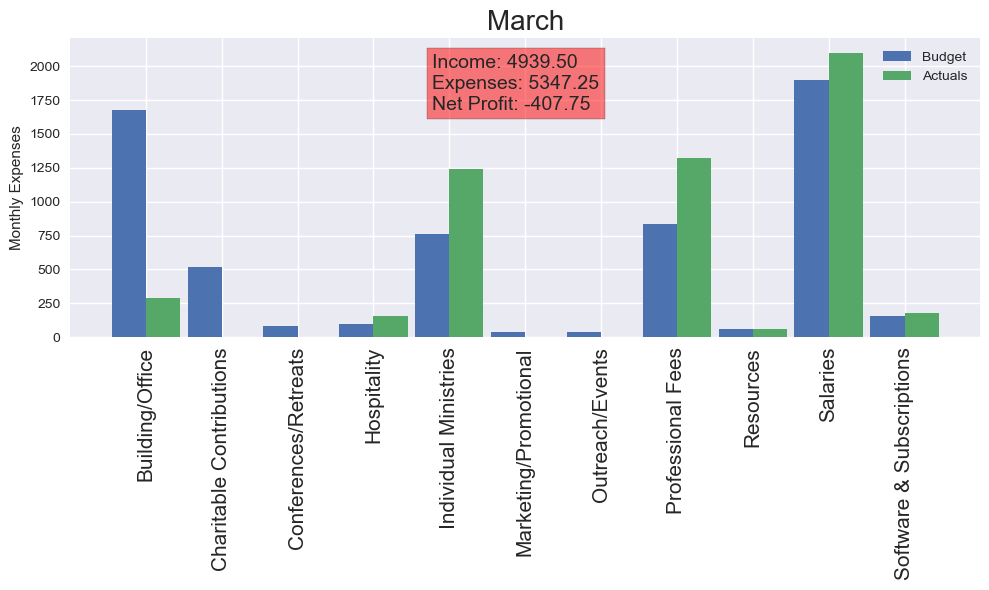

In [70]:
fig, ax = plt.subplots(figsize = (10,6))
ind = np.arange(len(subcategory_totals))
width = 0.45
budget = ax.bar(ind, subcategory_totals['Budget'], width, label = "Budget")
actual = ax.bar(ind+width, subcategory_totals["Amount"], width, label="Actuals")
ax.set_ylabel("Monthly Expenses")
ax.set_title(month_name, fontsize=20)
midx = ind.mean()
midy = max([subcategory_totals['Budget'].max(), subcategory_totals["Amount"].max()])*0.8
color = 'green'
if net_profit>0:
    color = 'green'
else:
    color = 'red'
ax.text(midx-1, midy, 'Income: {:.2f}\nExpenses: {:.2f}\nNet Profit: {:.2f}'.format(total_income,total_expense, net_profit), fontsize=14, bbox=dict(facecolor=color, alpha=0.5))
ax.legend()

ax.set_xticks(ind+width/2, subcategory_totals['Subcategory'], rotation=90, fontsize=15)
plt.tight_layout()
plt.savefig(f'{month_name}.png')

In [71]:
all_totals[~all_totals['item'].isin(['Lead Pastor','Associate Pastor'])].sort_values(['Amount'], ascending=False).head(10)[['Category','Subcategory','item','Amount']]

,Category,Subcategory,item,Amount
30,Ministry,Individual Ministries,Honorarium/Blessing,1200.00
16,Facilities,Professional Fees,Lawn/Snow,885.00
13,Facilities,Professional Fees,Utilities,367.15
7,Facilities,Building/Office,Repair and Maintenance,180.00
21,Facilities,Software & Subscriptions,Software and Subscriptions,176.16
20,Facilities,Hospitality,Food for Events/Sunday Morning,109.30
5,Facilities,Building/Office,Communications,81.23
32,Ministry,Resources,Right Now Media,59.99
17,Facilities,Professional Fees,Incorporation Fees,50.00
19,Facilities,Hospitality,Kitchen/Cleaning/Paper Supplies,46.48


In [54]:
month_name

'January'